In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import lombscargle
%matplotlib inline

DQTau1 = np.array([34.76, -2.93, 37.11, 37.38, 34.73, 31.64, 26.07, 23.51, 20.10, 17.31, 27.28, 36.99, 33.17,
                   35.11, 35.24, 28.81, 12.43, 40.09, 35.14, 35.89, 19.12, 37.08, 36.83, 12.75, -6.27, 14.82,
                   34.84,  3.16, 32.37, 39.09, 17.46, 22.67, 31.34])
DQTau2 = np.array([12.44, 56.13, 13.90, 15.01, 17.06, 20.70, 24.40, 27.30, 25.73, 27.86, 23.67, 7.64, 10.94,
                   09.87, 10.05, 19.93, 33.26, 13.83, 11.47, 16.98, 26.86, 10.20, 14.36, 23.86, 50.94, 37.61,
                   07.51, 52.75, 17.20, 08.27, 34.61, 26.25, 11.49])
HJD    = np.array([45982.0293, 46389.8446, 46745.8122, 47073.9364, 47075.9910, 47078.0084, 47127.8232, 47128.8081,
                   47159.6132, 47159.6318, 47427.9265, 47546.6122, 47546.6272, 47546.6272, 47546.6423, 47789.9412,
                   47840.8048, 47845.8709, 47896.7312, 47898.7686, 47902.6961, 48525.9580, 48670.6445, 48871.9572,
                   49344.8584, 49373.6908, 49410.6311, 49644.8270, 49699.8045, 53693.8806, 56578.9704, 56606.9106,
                   56650.8257])

system = np.genfromtxt('3325505.tbl', skip_header=1, usecols=(0, 1, 2))
JD  =[datum[0] for datum in system]
RVp =[datum[1] for datum in system]
RVs =[datum[2] for datum in system]
print(system)

[[  2.45584894e+06   4.66704000e+01   1.17086100e+02]
 [  2.45584992e+06   1.05416000e+02   4.70494000e+01]
 [  2.45592772e+06   4.73787000e+01   1.15104500e+02]
 [  2.45592870e+06   9.51597000e+01   5.88128000e+01]
 [  2.45593370e+06   7.81917000e+01   7.80146000e+01]
 [  2.45596770e+06   5.75387000e+01   1.05412500e+02]
 [  2.45626095e+06   1.09113700e+02   4.12546000e+01]
 [  2.45626792e+06   8.60607000e+01   6.87587000e+01]
 [  2.45628886e+06   6.12135000e+01   1.02065500e+02]
 [  2.45629087e+06   4.97614000e+01   1.14181300e+02]
 [  2.45631477e+06   4.65799000e+01   1.16995600e+02]
 [  2.45631576e+06   1.03232100e+02   4.80967000e+01]
 [  2.45632378e+06   1.07895800e+02   4.28864000e+01]]


In [2]:
#Throws an error, havent been able to get rid of it.
#this cell removes nan cells from the bad RV visits, and deletes the accompanying JDs 
#from a copy tied to the specific rv list

adjusted_JD = np.asarray(JD)
for i in range(0, np.asarray(JD).size-1):
#    if i == np.asarray(RVs).size:
#        break
    if np.isnan(RVs[i]):
        RVs         = np.delete(RVs, i)
        adjusted_JD = np.delete(adjusted_JD, i)

In [3]:
#This periodogram code was taken from
#Jake Vanderplas' "Fast Lomb-Scargle Periodograms in Python"
#modified by myself into a function

def periodogram(t, rv, f):
    
    t = np.array(t)
    rv = np.array(rv)
    
    delta_t = np.inf 
    for i in range(0, len(t)-2):
        if t[i+1]-t[i] < delta_t and t[i+1]-t[i] != 0:
            delta_t = t[i+1]-t[i]
    periods = np.linspace(2*delta_t, 5, num = f)

    # convert period range into frequency range
    ang_freqs = 2 * np.pi / periods

    # compute the (unnormalized) periodogram
    # note pre-centering of y values!
    powers = lombscargle(t, rv - rv.mean(), ang_freqs)

    # normalize the power
    N = len(t)
    powers *= 2 / (N * rv.std() ** 2)
    
    return periods, powers

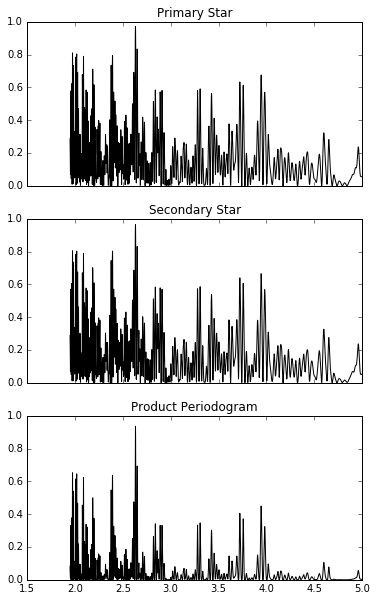

In [4]:
# plot the results
samples = 5000
x, y = periodogram(JD, RVp, samples)
y2   = periodogram(adjusted_JD, RVs, samples)[1]
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
ax1.plot(x, y, 'k')
ax1.set_title('Primary Star')
ax2.plot(x, y2, 'k')
ax2.set_title('Secondary Star')
ax3.plot(x, y*y2, 'k')
ax3.set_title('Product Periodogram')
fig.set_figheight(10)
fig.set_figwidth(6)
#fig.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
#plt.savefig('2M06115599+3325505 periodogram.png')

In [8]:
print(x[np.argmax(y)], x[np.argmax(y2)], x[np.argmax(y*y2)])

2.63178475684 2.63178475684 2.63178475684


All three periodogram peaks are equal for 2M06115599+3325505, indicating a period of 2.632 days